# Karan Kant (kk4ze)
# Coding Exercise 
# SAT Scores

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Initialize the spark environment (takes ~ 1min)

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

In [4]:
dataPath = "StudentsPerformance.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)


In [5]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)



In [6]:
df.head(10)

[Row(gender='female', race/ethnicity='group B', parental level of education="bachelor's degree", lunch='standard', test preparation course='none', math score=72, reading score=72, writing score=74),
 Row(gender='female', race/ethnicity='group C', parental level of education='some college', lunch='standard', test preparation course='completed', math score=69, reading score=90, writing score=88),
 Row(gender='female', race/ethnicity='group B', parental level of education="master's degree", lunch='standard', test preparation course='none', math score=90, reading score=95, writing score=93),
 Row(gender='male', race/ethnicity='group A', parental level of education="associate's degree", lunch='free/reduced', test preparation course='none', math score=47, reading score=57, writing score=44),
 Row(gender='male', race/ethnicity='group C', parental level of education='some college', lunch='standard', test preparation course='none', math score=76, reading score=78, writing score=75),
 Row(gender

In [7]:
# role = get_execution_role()
# bucket='odl-spark19spds6003-001'
# data_key = 'planecrash.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key) #read the bucket 
# pd.read_csv(data_location)

In [8]:
df = sqlc.createDataFrame(pd.read_csv('StudentsPerformance.csv')) #this will not work on big files

In [9]:
df

DataFrame[gender: string, race/ethnicity: string, parental level of education: string, lunch: string, test preparation course: string, math score: bigint, reading score: bigint, writing score: bigint]

In [10]:
df=df.withColumnRenamed("parental level of education","parentedu")
df=df.withColumnRenamed("test preparation score","testprepscore")
df=df.withColumnRenamed("math score","math")
df=df.withColumnRenamed("reading score","reading")
df=df.withColumnRenamed("writing score","writing")

In [11]:
df=df.withColumnRenamed("test preparation course","testsprepcourse")

In [12]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parentedu: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- testsprepcourse: string (nullable = true)
 |-- math: long (nullable = true)
 |-- reading: long (nullable = true)
 |-- writing: long (nullable = true)



### Save parquet

In [13]:
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/kk4ze3/test-parquet'

In [14]:
data = sqlc.read.parquet(parquetPath)
display(data)

DataFrame[gender: string, race/ethnicity: string, parentedu: string, lunch: string, testsprepcourse: string, math: bigint, reading: bigint, writing: bigint]

## Using MLlib

### Convention
* df = spark dataframe
* pddf = pandas dataframe

### Outline
1. make demo data frame
2. exploratory tools
3. feature engineering
4. train/test
5. vectorize (spark special sauce)
6. train
7. predict
8. eval

### Make a demo data frame

## MLlib Basics
* exploratory tools


In [16]:
display(df)

DataFrame[gender: string, race/ethnicity: string, parentedu: string, lunch: string, testsprepcourse: string, math: bigint, reading: bigint, writing: bigint]

In [17]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race/ethnicity: string (nullable = true)
 |-- parentedu: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- testsprepcourse: string (nullable = true)
 |-- math: long (nullable = true)
 |-- reading: long (nullable = true)
 |-- writing: long (nullable = true)



In [18]:
df.take(5)

[Row(gender='female', race/ethnicity='group B', parentedu="bachelor's degree", lunch='standard', testsprepcourse='none', math=72, reading=72, writing=74),
 Row(gender='female', race/ethnicity='group C', parentedu='some college', lunch='standard', testsprepcourse='completed', math=69, reading=90, writing=88),
 Row(gender='female', race/ethnicity='group B', parentedu="master's degree", lunch='standard', testsprepcourse='none', math=90, reading=95, writing=93),
 Row(gender='male', race/ethnicity='group A', parentedu="associate's degree", lunch='free/reduced', testsprepcourse='none', math=47, reading=57, writing=44),
 Row(gender='male', race/ethnicity='group C', parentedu='some college', lunch='standard', testsprepcourse='none', math=76, reading=78, writing=75)]

In [19]:
df

DataFrame[gender: string, race/ethnicity: string, parentedu: string, lunch: string, testsprepcourse: string, math: bigint, reading: bigint, writing: bigint]

In [20]:
print("Pearson's r(writing,reading) = {}".format(df.corr("writing", "reading"))) #pearson's correlation coefficient. Compute correlation between hits and R
# print("Pearson's r(HR,SO) = {}".format(df.corr("HR", "SO")))#compute correlation between home runs and strike outs
# print("Pearson's r(yearID,HR) = {}".format(df.corr("yearID", "HR")))

Pearson's r(writing,reading) = 0.954598077146248


### Select two features for analysis
* writing = feature
* reading = label

In [21]:
df = df.select("writing","reading")

## Finally, ML time
1. split data into train/test
2. **SPARK SPECIAL SAUCE** -  pysparki.ml.linalg - vectorization
3. Train --> Predict --> Evaluate

### Make Training and Test sets

In [22]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 812, test set N = 188


# VECTORIZATION - spark special sauce

In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-udfs.html
* User-Defined Functions (aka UDF) is a feature of Spark SQL to define new Column-based functions that extend the vocabulary of Spark SQL’s DSL for transforming Datasets.

In [24]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())
#convert to vector to take advantage of spark optimization
# vectorize the data frames
trainingDF = trainingDF.selectExpr("reading", "oneElementVec(writing) as writing")
testDF = testDF.selectExpr("reading", "oneElementVec(writing) as writing")

print(testDF.orderBy(testDF.reading.desc()).limit(5))

DataFrame[reading: bigint, writing: vector]


In [25]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("reading", "label").withColumnRenamed("writing", "features")
testDF = testDF.withColumnRenamed("reading", "label").withColumnRenamed("writing", "features")

In [26]:
trainingDF

DataFrame[label: bigint, features: vector]

## ML time for real
1. Train
2. Predict
3. Evaluate

In [27]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel  #create and fit regression model

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [28]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

We are now going to transform our test set to get predictions. It will append a prediction column to testDF in the new dataframe predictionsAndLabelsDF.

In [29]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=99, features=DenseVector([100.0]), prediction=98.634566730309), Row(label=95, features=DenseVector([94.0]), prediction=93.11072034046134), Row(label=93, features=DenseVector([93.0]), prediction=92.19007927548674), Row(label=93, features=DenseVector([93.0]), prediction=92.19007927548674), Row(label=92, features=DenseVector([86.0]), prediction=85.74559182066447)]


## Model Evaluation

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [31]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [32]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

4.523759514634758

In [33]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.8992520856629305

In [38]:
import matplotlib.pyplot as plt

In [37]:
predictionsAndLabelsDF.show()

+-----+--------+------------------+
|label|features|        prediction|
+-----+--------+------------------+
|   29|  [27.0]| 31.42776898716249|
|   38|  [27.0]| 31.42776898716249|
|   34|  [32.0]| 36.03097431203554|
|   38|  [32.0]| 36.03097431203554|
|   31|  [36.0]|39.713538571933974|
|   34|  [36.0]|39.713538571933974|
|   34|  [36.0]|39.713538571933974|
|   31|  [38.0]|41.554820701883195|
|   42|  [41.0]|44.316743896807026|
|   43|  [41.0]|44.316743896807026|
|   41|  [42.0]|45.237384961781636|
|   44|  [42.0]|45.237384961781636|
|   46|  [42.0]|45.237384961781636|
|   48|  [42.0]|45.237384961781636|
|   52|  [42.0]|45.237384961781636|
|   50|  [43.0]| 46.15802602675625|
|   51|  [43.0]| 46.15802602675625|
|   52|  [45.0]| 47.99930815670546|
|   52|  [46.0]| 48.91994922168007|
|   49|  [47.0]| 49.84059028665468|
+-----+--------+------------------+
only showing top 20 rows



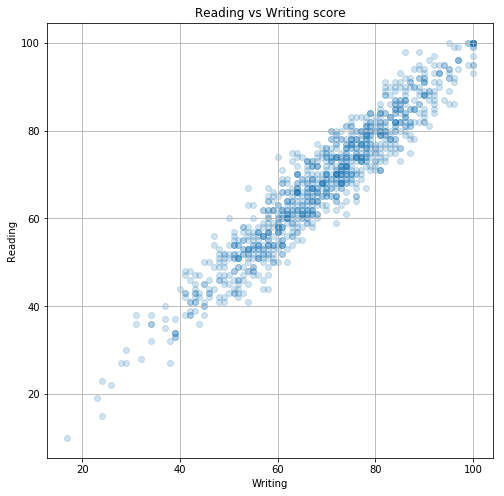

In [41]:
data = df.toPandas() # convert to pandas df for visualization
data = (data['reading'],data['writing'])
# Create plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.scatter(data[0], data[1], alpha=0.2)
plt.title("Reading vs Writing score")
plt.ylabel("Reading")
plt.xlabel("Writing")
plt.grid(True)
plt.show()